# predicting coronal mass ejections using machine learning methods

In this notebook, we will be predicting whether or not a flaring active region will also emit a Coronal Mass Ejection (CME). The analysis that follows is published in Bobra & Ilonidis, 2016, <i> Astrophysical Journal</i>. If you use any of this code, we ask that you cite our paper. <br>

Generally, active regions associated with large flares produce coronal mass ejections, but there have been some notable exceptions -- for example, the largest active region in the last 24 years, which appeared in October 2014, produced many large flares yet not a single CME. Here is the active region:

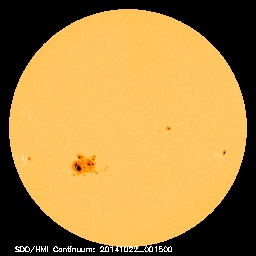

In [1]:
from IPython.display import Image
Image(url='http://jsoc.stanford.edu/data/hmi/images/2014/10/22/20141022_001500_Ic_flat_256.jpg',embed=True)

As such, our positive class will be flaring active regions that did produce a CME. Our negative class will be flaring active regions that did not produce a CME. Our features will be spaceweather keywords calculated from vector magnetic field data taken by the Helioseismic and Magnetic Imager instrument on NASA's Solar Dynamics Observatory (SDO) satellite. These features characterize the magnetic field at the solar surface, which is the only place that it is possible to infer the field directly (see [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) for more information on these keywords). SDO takes about a terabyte and a half of data a day, which is more data than any other satellite in NASA history. <br>

First, we'll import some modules.

In [2]:
import numpy as np, matplotlib.pylab as plt, matplotlib.mlab as mlab, pandas as pd, mpld3, requests, urllib, json
from datetime import datetime as dt_obj
from datetime import timedelta
from sklearn import svm
from sklearn import cross_validation
from mpld3 import plugins
from sunpy.time import TimeRange
import sunpy.instr.goes
from scipy.stats import pearsonr as pearse
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now we'll gather the data. The data come from three different places: 

1. CME data from SOHO/LASCO and STEREO/SECCHI coronographs, which can be accesed from the [DONKI database](http://kauai.ccmc.gsfc.nasa.gov/DONKI/) at NASA Goddard. This tells us if an active region has produced a CME or not.
2. Flare data from the GOES X-Ray Flux Monitor at NOAA, which can be accessed with the `sunpy.instr.goes.get_event_list()` function. This tells us if an active region produced a flare or not.
3. Active region data from the Solar Dynamics Observatory's Heliosesmic and Magnetic Imager instrument, which can be accessed from the [JSOC database](http://jsoc.stanford.edu/) via a JSON API. This gives us the features characterizing each active region.

### step 1: gathering data for the positive class

Let's first query the [DONKI database](http://kauai.ccmc.gsfc.nasa.gov/DONKI/) to get the data associated with the positive class. Be forewarned: there's a lot of data cleaning involved with building the positive class.

In [3]:
url = "http://kauai.ccmc.gsfc.nasa.gov/DONKI/search/"
search_param = {"eventName": "Solar Flare",
                "startSearchDate": "2010-05-01",
                "endSearchDate": "2015-07-01"}

t_start = search_param['startSearchDate']
t_end   = search_param['endSearchDate']

response = requests.post(url, data=search_param)
html = response.content
events = pd.read_html(html, attrs={'id':'FLR_table'})[0]

# get rid of the NaNs, as their presence disallows str.contains() function to be executed properly:
events = events.fillna('nothing')

# find all the events with CMEs
events = events[events['Directly Linked Event(s)'].str.contains("CME")]

# find all the flares that are M1.0-class or greater
events = events[events['Class'].str.contains("M|X")]

n_elements = len(events)
print "There are", n_elements, "possible CME events (positive class)."

# the following output is in the Stanford Digital Repository:
print "Class, Peak Time, Active Region Number, Directly Linked Event(s)"
for i in range(len(events)):
    print events['Class'].iloc[i],events['Peak Time'].iloc[i],events['Active Region Number'].iloc[i],events['Directly Linked Event(s)'].iloc[i]

There are 116 possible CME events (positive class).
Class, Peak Time, Active Region Number, Directly Linked Event(s)
X2.2 2011-02-15T01:56Z 11158.0 2011-02-15T02:25:00-CME-001
M3.5 2011-02-24T07:35Z 11163.0 2011-02-24T08:00:00-CME-001
M2.0 2011-03-07T14:30Z 11166.0 2011-03-07T14:40:00-CME-001
M3.7 2011-03-07T20:12Z 11164.0 2011-03-07T20:12:00-CME-001
M1.5 2011-03-08T03:58Z 11171.0 2011-03-08T05:00:00-CME-001
M2.5 2011-06-07T06:41Z 11226.0 2011-06-07T06:50:00-CME-001  2011-06-07T08:25:00-SEP-001  GOES13: SEM/EPS >10 MeV
M6.0 2011-08-03T13:48Z 11261.0 2011-08-03T13:55:00-CME-001
M9.3 2011-08-04T03:57Z 11261.0 2011-08-04T04:10:00-CME-001  2011-08-04T05:00:00-SEP-001  GOES13: SEM/EPS >100 MeV  2011-08-04T05:10:00-SEP-001  ACE: EPAM >30 MeV
X1.8 2011-09-07T22:38Z 11283.0 2011-09-07T23:24:00-CME-001
X1.4 2011-09-22T11:01Z nothing 2011-09-22T11:24:00-CME-001  2011-09-22T11:35:00-SEP-001  STEREO B: IMPACT 13-100 MeV
M8.7 2012-01-23T03:59Z 11402.0 2012-01-23T04:00:00-CME-001  2012-01-23T04:49:0

We've discovered that the DONKI database is, at times, unreliable. These issues tend to crop up:

1. On some occasions, the DONKI database has times for which both a CME and an M- or X-class flare occurred -- marking an example that would ordinarily go into the positive class -- but for which there is no NOAA active region number listed. However, the GOES flare database, maintained by the [National Centers for Environmental Information](http://ngdc.noaa.gov/), does have a NOAA active region number listed for this event. Thus, the DONKI database is incomplete for these times.
2. On some occasions, the DONKI database has a NOAA active region number listed that is different than the NOAA active region number listed in the GOES database. Thus, the DONKI database is incorrect for these occasions.
3. On some occastions, the DONKI database has a flare peak time that does not exist in the GOES database. Thus, the DONKI database is incorrect for these occasions.

Our best bet is to verify the DONKI data by comparing it to the GOES data. If, for any given event, both data are the same, then it's correct. To do this, we'll use the `instr.goes.get_goes_event_list()` function in SunPy, which requires a datetime object. So let's first convert all our times into datetime_objects.

In [4]:
def parse_tai_string(tstr):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    return dt_obj(year,month,day,hour,minute)

# create an array of datetime objects 
x = np.array([(parse_tai_string(events['Peak Time'].iloc[i])) for i in range(n_elements)])

Check for Case 1: In this case, the CME and flare exist but NOAA active region number does not exist in the DONKI database.

In [5]:
# Case 1: CME and Flare exist but NOAA active region number does not exist in DONKI database
number_of_donki_mistakes = 0
for i in range(n_elements):
    if (('CME' in str(events['Directly Linked Event(s)'].iloc[i])) and ('nothing' in str(events['Active Region Number'].iloc[i]))):
        time = x[i]
        time_range = TimeRange(time,time)
        listofresults = sunpy.instr.goes.get_goes_event_list(time_range,'M1')
        if (listofresults[0]['noaa_active_region'] == 0):
            continue
        else:
            print "Missing NOAA number:",events['Active Region Number'].iloc[i],events['Class'].iloc[i],events['Peak Time'].iloc[i],"should be",listofresults[0]['noaa_active_region'],"; changing now."
            events['Active Region Number'].iloc[i] = listofresults[0]['noaa_active_region']
            number_of_donki_mistakes += 1
print 'There are',number_of_donki_mistakes,'DONKI mistakes so far.'

Missing NOAA number: nothing X1.4 2011-09-22T11:01Z should be 11302 ; changing now.
Missing NOAA number: nothing X1.3 2012-03-07T01:14Z should be 11430 ; changing now.
Missing NOAA number: nothing M6.3 2012-03-09T03:53Z should be 11429 ; changing now.
Missing NOAA number: nothing M5.1 2012-05-17T01:47Z should be 11476 ; changing now.
Missing NOAA number: nothing X1.1 2012-07-06T23:08Z should be 11515 ; changing now.
Missing NOAA number: nothing M6.2 2012-07-28T20:56Z should be 11532 ; changing now.
Missing NOAA number: nothing M1.7 2012-11-08T02:23Z should be 11611 ; changing now.
Missing NOAA number: nothing X1.6 2013-05-13T02:17Z should be 11748 ; changing now.
Missing NOAA number: nothing X2.8 2013-05-13T16:05Z should be 11748 ; changing now.
Missing NOAA number: nothing X3.2 2013-05-14T01:11Z should be 11748 ; changing now.
Missing NOAA number: nothing X1.2 2013-05-15T01:48Z should be 11748 ; changing now.
Missing NOAA number: nothing M5.0 2013-05-22T13:38Z should be 11745 ; changi

Now we grab all the data from the GOES database in preparation for checking Cases 2 and 3.

In [6]:
# Grab all the data from the GOES database
time_range = TimeRange(t_start,t_end)
listofresults = sunpy.instr.goes.get_goes_event_list(time_range,'M1')
print 'Grabbed all the GOES data; there are',len(listofresults),'events.'
# the following output is in the Stanford Digital Repository:
print 'NOAA Active Region Number, Class, Peak Time'
for i in range(len(listofresults)):#
    print listofresults[i]['noaa_active_region'],listofresults[i]['goes_class'],listofresults[i]['peak_time']

Grabbed all the GOES data; there are 679 events.
NOAA Active Region Number, Class, Peak Time
11069 M1.2 2010-05-05 17:19:00
11081 M2.0 2010-06-12 00:57:00
11079 M1.0 2010-06-13 05:39:00
11093 M1.0 2010-08-07 18:24:00
11112 M2.9 2010-10-16 19:12:00
11121 M1.6 2010-11-04 23:58:00
1121 M1.6 2010-11-04 23:58:00
11121 M1.0 2010-11-05 13:29:00
11121 M5.4 2010-11-06 15:36:00
11149 M1.3 2011-01-28 01:03:00
11153 M1.9 2011-02-09 01:31:00
11158 M6.6 2011-02-13 17:38:00
11158 M2.2 2011-02-14 17:26:00
11158 X2.2 2011-02-15 01:56:00
0 M1.0 2011-02-16 01:39:00
11161 M1.1 2011-02-16 07:44:00
11158 M1.6 2011-02-16 14:25:00
11158 M6.6 2011-02-18 10:11:00
11162 M1.0 2011-02-18 10:26:00
11158 M1.4 2011-02-18 13:03:00
11162 M1.0 2011-02-18 14:08:00
11162 M1.3 2011-02-18 21:04:00
11163 M3.5 2011-02-24 07:35:00
11164 M1.1 2011-02-28 12:52:00
11164 M1.2 2011-03-07 05:13:00
11165 M1.5 2011-03-07 07:54:00
11164 M1.4 2011-03-07 08:07:00
11164 M1.8 2011-03-07 09:20:00
11166 M1.9 2011-03-07 14:30:00
11164 M3.7 20

Check for Case 2: In this case, the NOAA active region number is wrong in the DONKI database.

In [7]:
# Case 2: NOAA active region number is wrong in DONKI database
for i in range(len(listofresults)):
    match_peak_times = np.where(x == listofresults[i]['peak_time'])
    if (match_peak_times[0].size == 0):
        continue
    j = match_peak_times[0][0]
    if (events['Active Region Number'].iloc[j] == 'nothing'):
        continue
    if ((listofresults[i]['noaa_active_region']) != int(events['Active Region Number'].iloc[j])):
        print 'Messed up NOAA number:',int(events['Active Region Number'].iloc[j]),events['Class'].iloc[j],events['Peak Time'].iloc[j],"should be",listofresults[i]['noaa_active_region'],"; changing now."
        events['Active Region Number'].iloc[j] = listofresults[i]['noaa_active_region']
        number_of_donki_mistakes += 1
print 'There are',number_of_donki_mistakes,'DONKI mistakes so far.'

Messed up NOAA number: 11943 M4.0 2014-01-04T19:46Z should be 0 ; changing now.
Messed up NOAA number: 11943 X1.2 2014-01-07T18:32Z should be 11944 ; changing now.
Messed up NOAA number: 12051 M1.2 2014-05-07T16:29Z should be 12055 ; changing now.
Messed up NOAA number: 12160 M1.4 2014-07-01T11:23Z should be 12106 ; changing now.
Messed up NOAA number: 12282 M2.4 2015-02-09T23:35Z should be 12280 ; changing now.
Messed up NOAA number: 12280 M2.4 2015-02-09T23:35Z should be 12282 ; changing now.
Messed up NOAA number: 12282 M2.4 2015-02-09T23:35Z should be 0 ; changing now.
Messed up NOAA number: 12321 M1.1 2015-04-23T10:07Z should be 12322 ; changing now.
There are 23 DONKI mistakes so far.


Check for Case 3: In this case, the flare peak time is wrong in the DONKI database.

In [8]:
# Case 3: The flare peak time is wrong in the DONKI database.
goes_peak_times = np.array([listofresults[i]['peak_time'] for i in range(len(listofresults))])
for i in range(n_elements):
    this_peak_time = x[i]
    max_peak_time = this_peak_time + timedelta(0,0,0,0,6)
    min_peak_time = this_peak_time - timedelta(0,0,0,0,6)
    match_peak_times = (np.logical_and(goes_peak_times <= max_peak_time, goes_peak_times >= min_peak_time))
    if not any(match_peak_times):
        print 'DONKI flare peak time of',this_peak_time,'is not an actual GOES flare peak time. Flag event.'
        events['Peak Time'].iloc[i] = 'nothing'
        number_of_donki_mistakes += 1
print 'There are',number_of_donki_mistakes,'DONKI mistakes.'

DONKI flare peak time of 2012-03-10 17:27:00 is not an actual GOES flare peak time. Flag event.
There are 24 DONKI mistakes.


Now let's query the JSOC database to see if there are active region parameters at the time of the flare. First read the following file to map NOAA active region numbers to HARPNUMs (a HARP, or an HMI Active Region Patch, is the preferred numbering system for the HMI active regions as they appear in the magnetic field data before NOAA observes them in white light):

In [9]:
answer = pd.read_csv('http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt',sep=' ')

Now we can drop all rows that contain the value 'nothing' or 0 in the 'Active Region Number' column and create our final counts of how many events are in the positive or negative class:

In [10]:
# also drop elements where the noaa active region equals 'nothing' or 0
# the following assumes one match for match_nothing_ar or match_zero (could generalize this)
match_nothing_ar = np.where(events['Active Region Number'] == 'nothing')
match_zero = np.where(events['Active Region Number'] == 0)
if (match_nothing_ar[0].size > 0):
    events = events[events['Active Region Number'] != 'nothing']
if (match_zero[0].size > 0):
    events = events[events['Active Region Number'] != 0]

match_nothing_time = np.where(events['Peak Time'] == 'nothing')
if (match_nothing_time[0].size > 0):
    events = events[events['Peak Time'] != 'nothing']

n_elements = len(events)

Now, let's determine at which time we'd like to predict CMEs. In general, many people try to predict a CME either 24 or 48 hours before it happens. We can report both in this study by setting a variable called `timedelayvariable`:

In [11]:
timedelayvariable = 24

Now, we'll convert the GOES Peak Time format into one that JSOC can understand by generating arrays of both datetime objects and strings:

In [12]:
# subtract timedelayvariable hours before the GOES Peak Time and convert into a list of strings
def create_tai_string(x):
    t_rec = [] 
    for i in range(len(x)):
        x[i] = (x[i] - timedelta(hours=timedelayvariable))
        t_rec.append(x[i].strftime('%Y.%m.%d_%H:%M_TAI'))
    print "All times have been converted."
    return t_rec

In [13]:
# create an array of datetime objects 
x = np.array([(parse_tai_string(events['Peak Time'].iloc[i])) for i in range(n_elements)])
t_rec = create_tai_string(x)

All times have been converted.


Let's stuff the variable t_rec into the column 'Peak Time' and rename it to reflect its true values:

In [14]:
events = events.rename(columns={'Peak Time': 'One Day Before Peak Time'})
events['One Day Before Peak Time'] = t_rec

Now we can grab the SDO data from the JSOC database by executing the JSON queries. We are selecting data that satisfies several criteria: The data has to be [1] disambiguated with a version of the disambiguation module greater than 1.1, [2] taken while the orbital velocity of the spacecraft is less than 3500 m/s, [3] of a high quality, and [4] within 70 degrees of central meridian. If the data pass all these tests, they are stuffed into one of two lists: one for the positive class (called CME_data) and one for the negative class (called no_CME_data). Data are sorted into these two classes based on the presence of the string 'CME' 'Directly Linked Event(s)' column of the events dataframe. 

In [15]:
def get_the_jsoc_data():
    
    catalog_data = []
    classification = []
    
    for i in range(n_elements):
    
        print "=====",i,"====="
        # next match NOAA_ARS to HARPNUM
        idx = answer[answer['NOAA_ARS'].str.contains(str(int(listofactiveregions[i])))]
       
        # if there's no HARPNUM, quit
        if (idx.empty == True):
            print 'skip: there are no matching HARPNUMs for', str(int(listofactiveregions[i]))
            continue
        
        #construct jsoc_info queries and query jsoc database; we are querying for 25 keywords
        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s["+str(idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (CODEVER7 !~ '1.1 ') and (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH"
        response = urllib.urlopen(url)
        status = response.getcode()
    
        # if there's no response at this time, quit
        if status!= 200:
            print 'skip: failed to find JSOC data for HARPNUM',idx.HARPNUM.values[0],'at time', t_rec[i]
            continue
    
        # read the JSON output
        data = json.loads(response.read())
    
        # if there are no data at this time, quit
        if data['count'] == 0:
            print 'skip: there are no data for HARPNUM',idx.HARPNUM.values[0],'at time', t_rec[i]
            continue
    
        # check to see if the active region is too close to the limb
        # we can compute the latitude of an active region in stonyhurst coordinates as follows:
        # latitude_stonyhurst = CRVAL1 - CRLN_OBS
        # for this we have to query the CEA series (but above we queried the other series as the CEA series does not have CODEVER5 in it)

        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s["+str(idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=CRVAL1,CRLN_OBS"
        response = urllib.urlopen(url)
        status = response.getcode()
        
        # if there's no response at this time, quit
        if status!= 200:
            print 'skip: failed to find CEA JSOC data for HARPNUM',idx.HARPNUM.values[0],'at time', t_rec[i]
            continue
    
        # read the JSON output
        latitude_information = json.loads(response.read())

        # if there are no data at this time, quit
        if latitude_information['count'] == 0:
            print 'skip: there are no data for HARPNUM',idx.HARPNUM.values[0],'at time', t_rec[i]
            continue

        CRVAL1 = float(latitude_information['keywords'][0]['values'][0])
        CRLN_OBS = float(latitude_information['keywords'][1]['values'][0])
        if (np.absolute(CRVAL1 - CRLN_OBS) > 70.0):
            print 'skip: latitude is out of range for HARPNUM',idx.HARPNUM.values[0],'at time', t_rec[i]
            continue
            
        if ('MISSING' in str(data['keywords'])):
            print 'skip: there are some missing keywords for HARPNUM',idx.HARPNUM.values[0],'at time', t_rec[i]
            continue

        print 'printing data for NOAA Active Region number',str(int(listofactiveregions[i])),'and HARPNUM',idx.HARPNUM.values[0],'at time', t_rec[i]

        individual_flare_data = []
        for j in range(18):
            individual_flare_data.append(float(data['keywords'][j]['values'][0]))
    
        catalog_data.append(list(individual_flare_data))
    
        single_class_instance = [idx.HARPNUM.values[0],str(int(listofactiveregions[i])),listofgoesclasses[i],t_rec[i]]
        classification.append(single_class_instance)

    return catalog_data, classification

Now we prepare the data to be fed into the function:

In [16]:
listofactiveregions = list(events['Active Region Number'].values.flatten())
listofgoesclasses = list(events['Class'].values.flatten())

And call the function:

In [17]:
positive_result = get_the_jsoc_data()

===== 0 =====
printing data for NOAA Active Region number 11158 and HARPNUM 377 at time 2011.02.14_01:56_TAI
===== 1 =====
skip: there are no data for HARPNUM 392 at time 2011.02.23_07:35_TAI
===== 2 =====
printing data for NOAA Active Region number 11166 and HARPNUM 401 at time 2011.03.06_14:30_TAI
===== 3 =====
printing data for NOAA Active Region number 11164 and HARPNUM 393 at time 2011.03.06_20:12_TAI
===== 4 =====
skip: there are no data for HARPNUM 415 at time 2011.03.07_03:58_TAI
===== 5 =====
printing data for NOAA Active Region number 11226 and HARPNUM 637 at time 2011.06.06_06:41_TAI
===== 6 =====
printing data for NOAA Active Region number 11261 and HARPNUM 750 at time 2011.08.02_13:48_TAI
===== 7 =====
printing data for NOAA Active Region number 11261 and HARPNUM 750 at time 2011.08.03_03:57_TAI
===== 8 =====
printing data for NOAA Active Region number 11283 and HARPNUM 833 at time 2011.09.06_22:38_TAI
===== 9 =====
skip: there are no data for HARPNUM 892 at time 2011.09.2

Here is the list of events associated with the positive class:

In [18]:
CME_data = positive_result[0]
positive_class = positive_result[1]
# the following output is in the Stanford Digital Repository:
print "There are", len(CME_data), "CME events (positive class)."
print "HARPNUM, NOAA Number, Class, Peak Time, USFLUX, MEANGBT, MEANJZH, MEANPOT, SHRGT45, TOTUSJH, MEANGBH, MEANALP, MEANGAM, MEANGBZ, MEANJZD, TOTUSJZ, SAVNCPP, TOTPOT, MEANSHR, AREA_ACR, R_VALUE, ABSNJZH"
for i in range(len(CME_data)):
    print positive_class[i][0], positive_class[i][1], positive_class[i][2], positive_class[i][3],positive_result[0][i][0],positive_result[0][i][1],positive_result[0][i][2],positive_result[0][i][3],positive_result[0][i][4],positive_result[0][i][5],positive_result[0][i][6],positive_result[0][i][7],positive_result[0][i][8],positive_result[0][i][9],positive_result[0][i][10],positive_result[0][i][11],positive_result[0][i][12],positive_result[0][i][13],positive_result[0][i][14],positive_result[0][i][15],positive_result[0][i][16],positive_result[0][i][17]

There are 56 CME events (positive class).
HARPNUM, NOAA Number, Class, Peak Time, USFLUX, MEANGBT, MEANJZH, MEANPOT, SHRGT45, TOTUSJH, MEANGBH, MEANALP, MEANGAM, MEANGBZ, MEANJZD, TOTUSJZ, SAVNCPP, TOTPOT, MEANSHR, AREA_ACR, R_VALUE, ABSNJZH
377 11158 X2.2 2011.02.14_01:56_TAI 2.292718e+22 103.723 0.01958899 14129.66 56.345 3015.888 74.86 0.04121538 60.431 111.241 0.10676716 5.414409e+13 1.196893e+13 7.140573e+23 51.393 945.314636 4.805 745.381
401 11166 M2.0 2011.03.06_14:30_TAI 2.352848e+22 90.899 -0.00173849 9597.931 45.475 1744.633 54.893 -0.00405663 51.832 95.061 0.13252671 3.944855e+13 5.053109e+12 4.864565e+23 44.73 961.502686 4.303 66.343
393 11164 M3.7 2011.03.06_20:12_TAI 6.354885e+22 89.238 0.00668007 8901.316 28.829 4435.788 47.789 0.01490614 41.47 97.15 -0.07817341 8.578735e+13 3.416153e+13 1.096926e+24 36.08 1934.446167 4.842 619.857
637 11226 M2.5 2011.06.06_06:41_TAI 2.65294e+22 104.938 0.0076348 3160.181 14.941 1671.507 45.459 0.02924855 35.535 105.271 0.01902856 3.907

### step 2: gathering data for the negative class

To gather the examples for the negative class, we only need to query the GOES database for all the M- and X-class flares in our time of interest, and select the ones that are not associated with a CME. If a flare appears in the positive class, we reject it. If not, it qualifies for the negative class.

This filter is more rigorous than it needs to be. Since the DONKI and GOES database peak times don't match, this filter seeks one flare match between the DONKI and GOES database within a span of 12 minutes. If there are more than flare matches within this time, all of them will be rejected from the negative class -- even the flare existed in teh GOES database but was not in the DONKI database. But that's okay, because the classes are already massively imbalanced, and having a few less negative class events than maximally possible will still give the same result.

In [19]:
# select peak times that belong to both classes
all_peak_times = np.array([(listofresults[i]['peak_time']) for i in range(len(listofresults))])

#select peak times that belong to the positive class
positive_peak_times = np.array([(parse_tai_string(positive_class[i][3])) + timedelta(hours=timedelayvariable) for i in range(len(positive_class))])

negative_class_possibilities = [] 
counter_positive = 0
counter_negative = 0
for i in range(len(listofresults)):
    if (listofresults[i]['noaa_active_region'] < 10000):
        continue
    this_peak_time = all_peak_times[i]
    max_peak_time = this_peak_time + timedelta(0,0,0,0,6)
    min_peak_time = this_peak_time - timedelta(0,0,0,0,6)
    match_peak_times = np.where((np.logical_and(positive_peak_times <= max_peak_time, positive_peak_times >= min_peak_time)) == True)
    if (match_peak_times[0].shape[0] == 1):
        counter_positive +=1
    else:
        counter_negative += 1
        this_instance = [listofresults[i]['noaa_active_region'],listofresults[i]['goes_class'],listofresults[i]['peak_time']]
        negative_class_possibilities.append(this_instance)
print "There are", counter_positive,"maximal events in the positive class (the true number may be less than this)."
print "There are",counter_negative,"possible events in the negative class."

There are 57 maximal events in the positive class (the true number may be less than this).
There are 590 possible events in the negative class.


Again, we compute times that are one day before the flare peak time:

In [20]:
# create an array of datetime objects 
x = np.array([negative_class_possibilities[i][2] for i in range(len(negative_class_possibilities))])
t_rec = create_tai_string(x)
n_elements = len(t_rec)

All times have been converted.


And again, we query the JSOC database to see if these data are present:

In [21]:
listofactiveregions = list(negative_class_possibilities[i][0] for i in range(n_elements))
listofgoesclasses = list(negative_class_possibilities[i][1] for i in range(n_elements))

In [22]:
negative_result = get_the_jsoc_data()

===== 0 =====
printing data for NOAA Active Region number 11069 and HARPNUM 8 at time 2010.05.04_17:19_TAI
===== 1 =====
skip: there are no data for HARPNUM 54 at time 2010.06.11_00:57_TAI
===== 2 =====
printing data for NOAA Active Region number 11079 and HARPNUM 49 at time 2010.06.12_05:39_TAI
===== 3 =====
printing data for NOAA Active Region number 11093 and HARPNUM 115 at time 2010.08.06_18:24_TAI
===== 4 =====
printing data for NOAA Active Region number 11112 and HARPNUM 211 at time 2010.10.15_19:12_TAI
===== 5 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.03_23:58_TAI
===== 6 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.04_13:29_TAI
===== 7 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.05_15:36_TAI
===== 8 =====
printing data for NOAA Active Region number 11149 and HARPNUM 345 at time 2011.01.27_01:03_TAI
===== 9 =====
printing data for NOAA Active Region number 11153 and HARPNUM 362 at time 2011.02.08_01:31_T

Here is the list of events associated with the negative class:

In [23]:
no_CME_data = negative_result[0]
negative_class = negative_result[1]
# the following output is in the Stanford Digital Repository:
print "There are", len(no_CME_data), "no-CME events (negative class)."
print "HARPNUM, NOAA Number, Class, Peak Time, USFLUX, MEANGBT, MEANJZH, MEANPOT, SHRGT45, TOTUSJH, MEANGBH, MEANALP, MEANGAM, MEANGBZ, MEANJZD, TOTUSJZ, SAVNCPP, TOTPOT, MEANSHR, AREA_ACR, R_VALUE, ABSNJZH"
for i in range(len(no_CME_data)):
    print negative_class[i][0], negative_class[i][1], negative_class[i][2], negative_class[i][3],negative_result[0][i][0],negative_result[0][i][1],negative_result[0][i][2],negative_result[0][i][3],negative_result[0][i][4],negative_result[0][i][5],negative_result[0][i][6],negative_result[0][i][7],negative_result[0][i][8],negative_result[0][i][9],negative_result[0][i][10],negative_result[0][i][11],negative_result[0][i][12],negative_result[0][i][13],negative_result[0][i][14],negative_result[0][i][15],negative_result[0][i][16],negative_result[0][i][17]

There are 364 no-CME events (negative class).
HARPNUM, NOAA Number, Class, Peak Time, USFLUX, MEANGBT, MEANJZH, MEANPOT, SHRGT45, TOTUSJH, MEANGBH, MEANALP, MEANGAM, MEANGBZ, MEANJZD, TOTUSJZ, SAVNCPP, TOTPOT, MEANSHR, AREA_ACR, R_VALUE, ABSNJZH
8 11069 M1.2 2010.05.04_17:19_TAI 4.449269e+21 135.195 -0.04832249 9042.597 16.629 578.638 80.932 -0.07553489 37.238 156.727 -0.58707803 7.65943e+12 8.938259e+12 5.892802e+22 29.87 171.006271 4.072 237.118
49 11079 M1.0 2010.06.12_05:39_TAI 1.486036e+21 126.492 -0.00718197 5160.053 0.867 108.345 55.345 -0.00801632 24.466 132.485 -1.20177364 1.2109e+12 8.275082e+11 8.696179e+21 18.178 48.475544 3.192 9.114
115 11093 M1.0 2010.08.06_18:24_TAI 1.182141e+22 91.151 -0.01023015 10387.6 24.226 692.913 42.381 -0.01814705 37.119 93.933 -0.10954364 1.050618e+13 1.335246e+12 2.027204e+23 31.859 470.634491 3.818 150.332
211 11112 M2.9 2010.10.15_19:12_TAI 7.07632e+21 138.784 0.00260818 4582.969 9.572 568.726 69.917 0.00590971 34.312 143.935 1.40421236 9.57

### step 3: feature selection

Now we will add another feature, the flare class, to our analysis just for the feature selection part. The flare class is similar in concept to the flare index, described in [Antalová (1996)](http://adsabs.harvard.edu/abs/1996CoSka..26...98A), except it is calculated for one flare. We define the flare class $FC$ as follows: $FC = CM$ where $C$ is a constant that equals 10.0 in the case of X-class flares and 1.0 in the case of M-class flares and $M$ is the magnitude of the flare. Of course, we can't a priori know the class of a flare in a real-time scenario. However, it is interesting from a scientific point of view, rather than a prediction point of view, to see if the flare class does a good job of distinguishing between the events in the positive and negative class.

In [24]:
def create_flare_class(type_of_class):
    total_flare_class = []
    for i in range(len(type_of_class)):
        magnitude = float(type_of_class[i][2][1:4])
        flareclass = type_of_class[i][2][0]
        if (flareclass == 'M'):
            factor = 1.0
        if (flareclass == 'X'):
            factor = 10.0
        total_flare_class.append(factor*magnitude)
    return total_flare_class

In [25]:
positive_flare_class = np.array(create_flare_class(positive_class))
negative_flare_class = np.array(create_flare_class(negative_class))

Now we'll convert our data into numpy arrays and add the flare index as an additional feature:

In [26]:
CME_data = np.array(CME_data)
no_CME_data = np.array(no_CME_data)

In [27]:
CME_data = np.column_stack((CME_data, positive_flare_class))
no_CME_data = np.column_stack((no_CME_data, negative_flare_class))
print "Now we have", CME_data.shape[1], "features."

Now we have 19 features.


To improve the performance of the feature selection algorithm, we'll normalize each feature so that they lie within similar ranges. To do this, we subtract from every feature its median value and divide by its standard deviation.

In [28]:
def normalize_the_data(flare_data):
    flare_data = np.array(flare_data)
    n_elements = flare_data.shape[0]
    for j in range(flare_data.shape[1]):
        standard_deviation_of_this_feature = np.std(flare_data[:,j])
        median_of_this_feature = np.median(flare_data[:,j])
        for i in range(n_elements):
            flare_data[i,j] = (flare_data[i,j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return flare_data

no_CME_data = normalize_the_data(no_CME_data)
CME_data = normalize_the_data(CME_data)

print "There are", no_CME_data.shape[0], "flares with no associated CMEs."
print "There are", CME_data.shape[0], "flares with associated CMEs."

There are 364 flares with no associated CMEs.
There are 56 flares with associated CMEs.


Let's look at the distribution of one feature for the active regions that both flared and produced a CME (green) and for the active regions that flared but did not produce a CME (red):

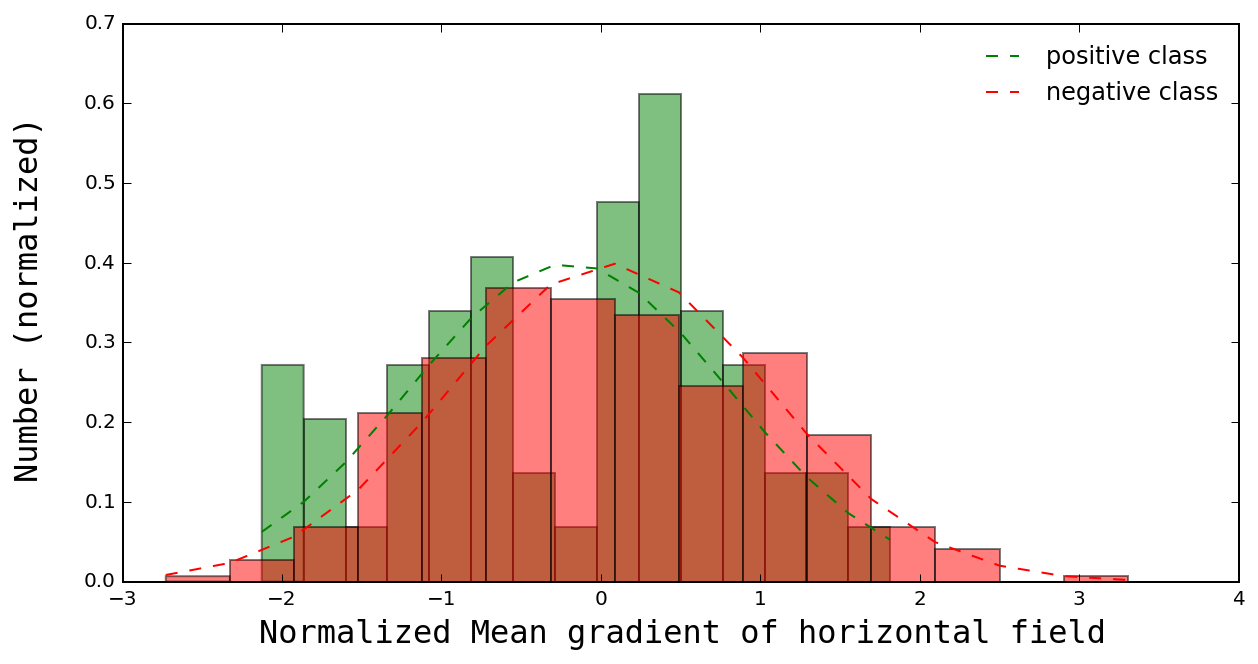

In [29]:
sharps = ['Total unsigned flux', 'Mean gradient of total field', 
'Mean current helicity (Bz contribution)', 'Mean photospheric magnetic free energy',
'Fraction of Area with Shear > 45 deg', 'Total unsigned current helicity',
'Mean gradient of horizontal field', 'Mean characteristic twist parameter, alpha',
'Mean angle of field from radial', 'Mean gradient of vertical field', 
'Mean vertical current density', 'Total unsigned vertical current', 
'Sum of the modulus of the net current per polarity',
'Total photospheric magnetic free energy density', 'Mean shear angle',
'Area of strong field pixels in the active region', 'Sum of flux near polarity inversion line',
'Absolute value of the net current helicity','Flare index']

i=6

# For the positive class (green)
mu_fl = np.mean(CME_data[:,i])
sigma_fl = np.std(CME_data[:,i])
num_bins = 15
n_fl, bins_fl, patches_fl = plt.hist(CME_data[:,i], num_bins, normed=1, facecolor='green', alpha=0.5)
y_fl = mlab.normpdf(bins_fl, mu_fl, sigma_fl)
plt.plot(bins_fl, y_fl, 'g--',label='positive class')

# For the negative class (red)
mu_nofl = np.mean(no_CME_data[:,i])
sigma_nofl = np.std(no_CME_data[:,i])
n_nofl, bins_nofl, patches_nofl = plt.hist(no_CME_data[:,i], num_bins, normed=1, facecolor='red', alpha=0.5)
y_nofl = mlab.normpdf(bins_nofl, mu_nofl, sigma_nofl)
plt.plot(bins_nofl, y_nofl, 'r--',label='negative class')

text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
plt.xlabel('Normalized '+sharps[i],**text_style)
plt.ylabel('Number (normalized)', labelpad=20,**text_style)
fig = plt.gcf()
fig.set_size_inches(10,5)
fig.savefig('fscore_tmp.png',bbox_inches='tight')
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0,title='')
legend.get_frame().set_linewidth(0.0)
mpld3.enable_notebook()

You can change the value of `i` in the code block above to see that some features are totally useless as there is barely any difference in the distributions for the positive and negative class. As such, we can throw such features out of our sample. It's a good idea to do some feature selection before running the SVM, so as to reduce noise (in this case, with only 19 features, there's not too much noise to begin with). Here we will be computing the Univariate F-score for feature selection. It is a very simple method: the F-score measures the distance between the two distributions for a given feature (inter-class distance), divided by the sum of the variances for this feature (intra-class distance). We can use the `sklearn.feature_selection` module to do this:

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif  # import the feature selection method
N_features = 19                                               # select the number of features 
Nfl = CME_data.shape[0]; Nnofl = no_CME_data.shape[0]
yfl = np.ones(Nfl); ynofl = np.zeros(Nnofl)
selector = SelectKBest(f_classif, k=N_features)               # k is the number of features
selector.fit(np.concatenate((CME_data,no_CME_data),axis=0), np.concatenate((yfl, ynofl), axis=0))
scores=selector.scores_
print scores

[  2.53461527e-01   1.08256432e+00   2.34930569e+00   9.80033450e-01
   6.89968938e-01   2.48195755e-02   3.12394886e+00   1.47724089e+00
   1.74910927e-01   7.41645634e-04   2.79576389e-01   1.38229396e-01
   5.70836323e-03   3.10906652e-01   9.07150618e-01   1.04641940e-01
   4.83759321e-02   1.30749939e-01   1.18446337e-02]


It's not easy to interpret the scores in this fashion, so let's plot the results:

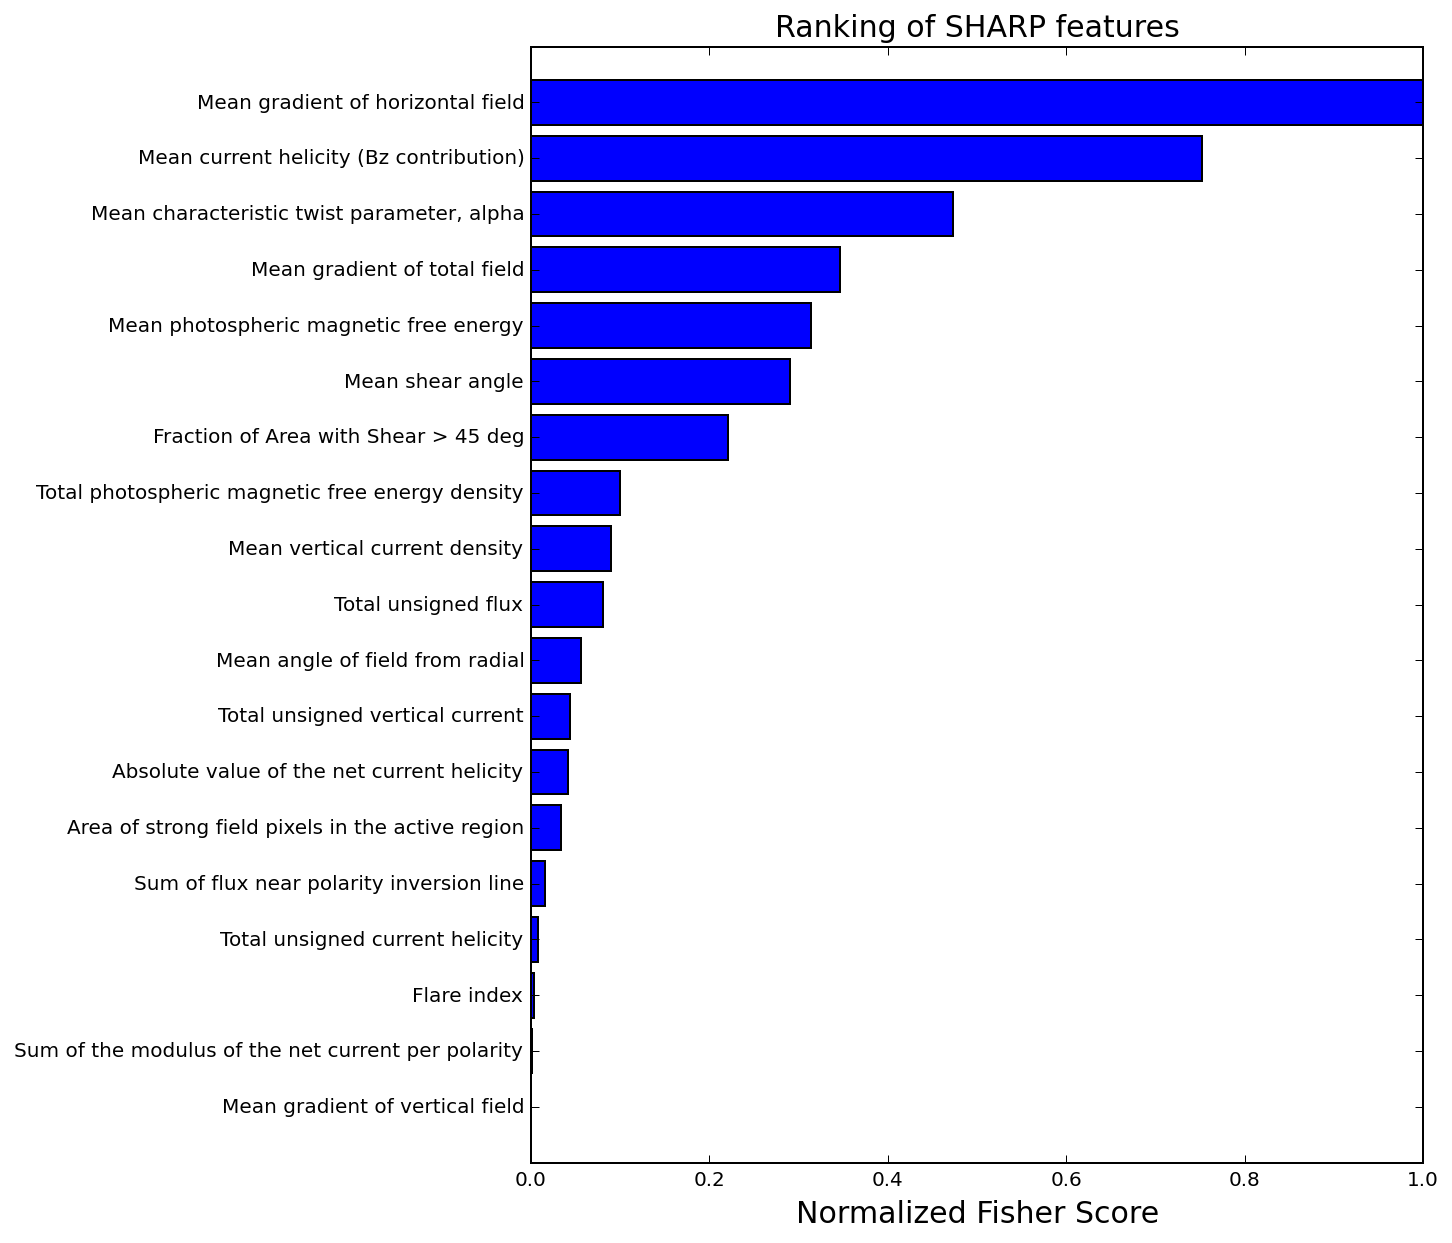

In [31]:
mpld3.disable_notebook()
plt.clf()
order = np.argsort(scores)
orderedsharps = [sharps[i] for i in order]
y_pos2 = np.arange(19)
plt.barh(y_pos2, sorted(scores/np.max(scores)), align='center')
plt.ylim((-1, 19))
plt.yticks(y_pos2, orderedsharps)
plt.xlabel('Normalized Fisher Score', fontsize=15)
plt.title('Ranking of SHARP features', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(8,10)
fig.savefig('sharp_ranking_48hours.png',bbox_inches='tight')
plt.show()

If we're interested, we can compute the Pearson linear correlation coefficients between any pair of features:

In [32]:
xdata = np.concatenate((CME_data, no_CME_data), axis=0)
ydata = np.concatenate((np.ones(Nfl), np.zeros(Nnofl)), axis=0)

In [33]:
for i in range(len(sharps)):
    for j in range(len(sharps)):
        x = pearse(xdata[:,i],xdata[:,j])
        print "The correlation between",sharps[i],"and",sharps[j],"is",x[0],"."

The correlation between Total unsigned flux and Total unsigned flux is 1.0 .
The correlation between Total unsigned flux and Mean gradient of total field is -0.397713891503 .
The correlation between Total unsigned flux and Mean current helicity (Bz contribution) is -0.118608160664 .
The correlation between Total unsigned flux and Mean photospheric magnetic free energy is 0.436100764084 .
The correlation between Total unsigned flux and Fraction of Area with Shear > 45 deg is 0.0702149438718 .
The correlation between Total unsigned flux and Total unsigned current helicity is 0.929530254221 .
The correlation between Total unsigned flux and Mean gradient of horizontal field is -0.282579895565 .
The correlation between Total unsigned flux and Mean characteristic twist parameter, alpha is -0.111692421924 .
The correlation between Total unsigned flux and Mean angle of field from radial is -0.0559695300631 .
The correlation between Total unsigned flux and Mean gradient of vertical field is -0.

We see that the flare class is poorly ranked using the F-score; further, we cannot use this feature in a real-time setting. As such, we'll eliminate this feature before we go on to run the classifier.

In [34]:
CME_data = CME_data[:,0:18]
no_CME_data = no_CME_data[:,0:18]
print "Now we are back to", CME_data.shape[1], "features."

Now we are back to 18 features.


Now we can run the classifier, a support vector machine using the `sklearn.svm` module:

### step 4: the support vector machine

Now we run the support vector machine on the data. The SVM uses non-linear decision functions to map the feature space into a higher-dimensional space, where the positive and negative examples can be separated linearly by a hyperplane. 

In [35]:
number_of_examples = Nfl + Nnofl
C = 4.0; gamma = 0.075; class_weight = {1:6.5}
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight=class_weight, cache_size=500, max_iter=-1, shrinking=True, tol=1e-8)

###step 5: stratified k-folds cross-validation

Now we evaluate the performance of the SVM. There are many different ways to do this. In our case, the positive sample size is quite small (both objectively and compared to the negative sample size). So one particular way we can cross validate our results is to use the stratified k-folds cross-validation method, which makes k partitions of the data set and uses k-1 folds for training and 1 fold for testing. The stratification preserves the ratio of positive to negative examples per fold. Then we can permute over the partitions such that each partition eventually makes its way into the testing set. For each individual testing set, we can calculate a skill score. Then we can average the skill scores over the total number of testing sets. 

First, let's define a confusion table to measure the performance of our binary classification by computing the sensitivity, specificity, false positive, and false negative rates:

In [36]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score
  
    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)
  
    Returns: true negative, false positive, true positive, false negative
    """  
    Nobs = len(pred)
    TN = 0.; TP = 0.; FP = 0.; FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1 
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print "Error! Observation could not be classified."
    return TN,FP,TP,FN

We prefer the True Skill Score (TSS) to all the other metrics as it is insensitive to the class imbalance ratio and thus best for comparison to other groups. The TSS is symmetrically distributed about 0: i.e., it goes from [-1, 1] where 0 represents no skill and a negative value represents a perverse prediction. Thus we are able to predict CMEs in a fashion better than randomly guessing. To compute the TSS, we must first select a value of k. k can be arbitrarily defined and take any value between 2 and `number_of_examples`, so we can explore this parameter space. As k approaches `number_of_examples`, the k-fold method reduces to the Leave One Out method, in which only one example is in the testing set and all other examples are in the training set. The literature suggests this method is not the best, so we can stray away from high values of k. Many studies (e.g. [Kohavi, 1995](http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf)) recommend the stratified 10-fold cross-validation to reduce variance and bias. Here, we test their recommendation by computing the TSS using 50 k values, ranging from 2 to 52.

In [37]:
array_of_avg_TSS = np.ndarray([50])
array_of_std_TSS = np.ndarray([50])
pred = -np.ones(number_of_examples)
xdata = np.concatenate((CME_data, no_CME_data), axis=0)
ydata = np.concatenate((np.ones(Nfl), np.zeros(Nnofl)), axis=0)
shuffle_index = np.arange(number_of_examples)                  # shuffle the data indices 
np.random.shuffle(shuffle_index)
ydata_shuffled = ydata[shuffle_index]
xdata_shuffled = xdata[shuffle_index,:]
for k in range(2,52):
    skf = cross_validation.StratifiedKFold(ydata_shuffled, n_folds=k)
    these_TSS_for_this_k = []
    for j, i in skf: 
        train = xdata_shuffled[j]; test = xdata_shuffled[i]     # test is examples in testing set; train is examples in training set
        ytrain = ydata_shuffled[j]; ytest = ydata_shuffled[i]   # ytest is labels in testing set; ytrain is labels in training set
        clf.fit(train, ytrain)
        pred[i] = clf.predict(test)
        TN,FP,TP,FN = confusion_table(pred[i], ydata_shuffled[i])
        if (((TP+FN) == 0.0) or (FP+TN)==0.0):
            these_TSS_for_this_k.append(-1.0)
            continue
        else:
            these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
    TSS_k = np.array(these_TSS_for_this_k)
    array_of_avg_TSS[k-2]=np.mean(TSS_k)
    array_of_std_TSS[k-2]=np.std(TSS_k)

Now we can plot the mean TSS per k, using the standard deviation as the error in the TSS. We see that for high values of k, the standard deviation in the TSS can be greater than the mean. These points are indicated in blue.

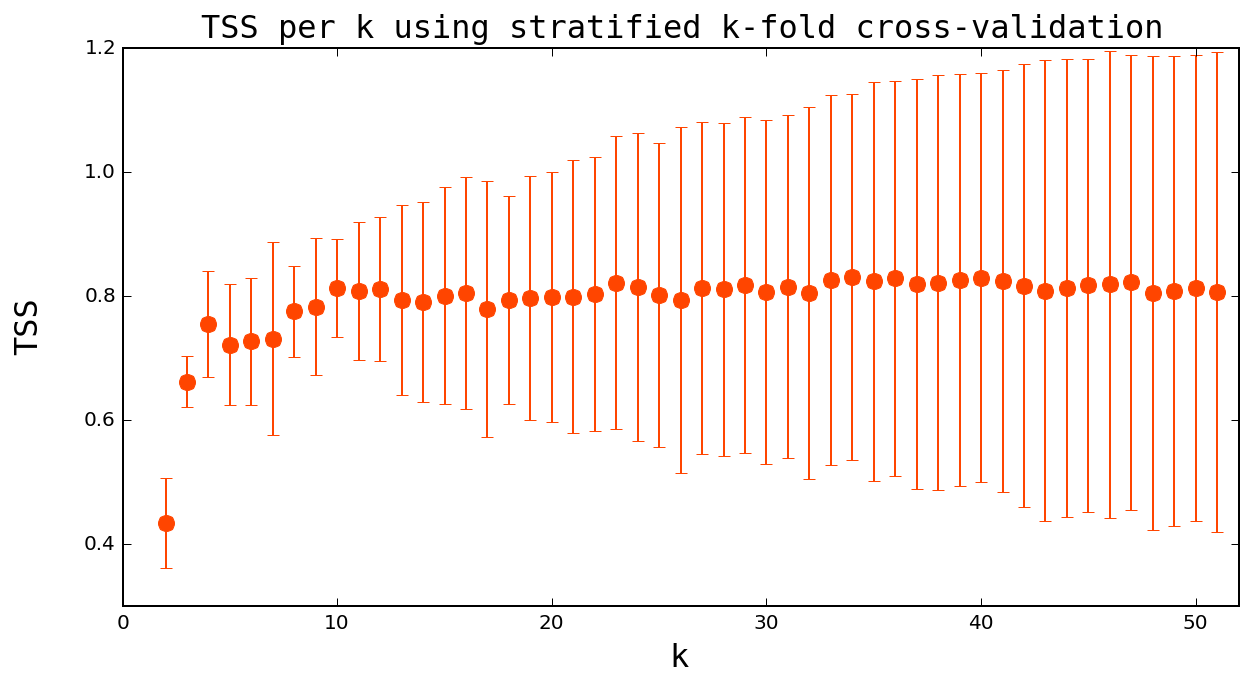

In [38]:
fig, ax = plt.subplots(figsize=(10,8))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color
cornblue  = (0.39,0.58,0.93,1.0)            # create a cornflower-blue color

# define some style elements
marker_style_red  = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
marker_style_blue = dict(linestyle='', markersize=8, fillstyle='full',color=cornblue,markeredgecolor=cornblue)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})

# ascribe the data to the axes
k = np.arange(50)+2
for i in range(50):
    if (array_of_avg_TSS[i] > array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i], yerr=array_of_std_TSS[i], linestyle='',color=orangered)
        ax.plot(k[i], array_of_avg_TSS[i],'o',**marker_style_red)
    if (array_of_avg_TSS[i] <= array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i], yerr=array_of_std_TSS[i], linestyle='',color=cornblue)
        ax.plot(k[i], array_of_avg_TSS[i],'o',**marker_style_blue)
plt.xlim(xmax = 52, xmin = 0)

# label the axes and the plot
ax.set_xlabel('k',**text_style)
ax.set_ylabel('TSS',labelpad=20,**text_style)
plt.title(r'TSS per k using stratified k-fold cross-validation',**text_style)
fig = plt.gcf()
fig.set_size_inches(10,5)
mpld3.enable_notebook()

As such, we confirm that high k-values result in a high variance. We find it reasonable to use the stratified 10-fold cross-validation method to compute the TSS and will follow this recommendation. The TSS reported below may not be exactly the same as that in the paper as the `np.shuffle` function performs a randomization that is impossible to reproduce exactly; however the TSS reported in the paper will be within the computed error:

In [39]:
print "The TSS equals",array_of_avg_TSS[8],"plus or minus",array_of_std_TSS[8]

The TSS equals 0.812372372372 plus or minus 0.0791606116606
